# Ứng dụng phân loại bệnh sử dụng mô hình Vision Transformer

# 1. Thư viện sử dụng

In [1]:
# Sử dụng torch làm chính
import torch
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import timm # Thư viện PyTorch Image Models

import numpy as np
import cv2 # OpenCV
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix # 6. Đánh giá mô hình
from tqdm.notebook import tqdm
import os
import shutil # 3.1. Copy files từ dataset gốc để chia dữ liệu
import random # Dùng để shuffle dataset ở # 2.2 và 3.1
import copy # 5. Dùng deep copy để khôi phục mô hình tốt nhất

# 2. Khám phá dữ liệu

## 2.1. Phân phối ảnh của mỗi lớp

Phân tích phân phối số lượng hình ảnh trong mỗi lớp để xem dữ liệu có cân bằng hay không.

Trực quan hóa: Sử dụng biểu đồ pie và biểu đồ cột.

Class distribution:
pneumonia: 2313 images
normal: 2313 images
covid: 2313 images


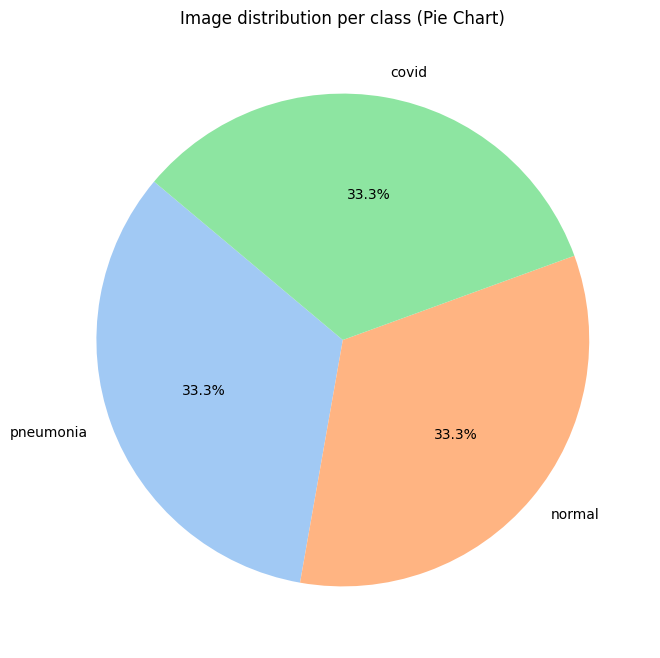

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


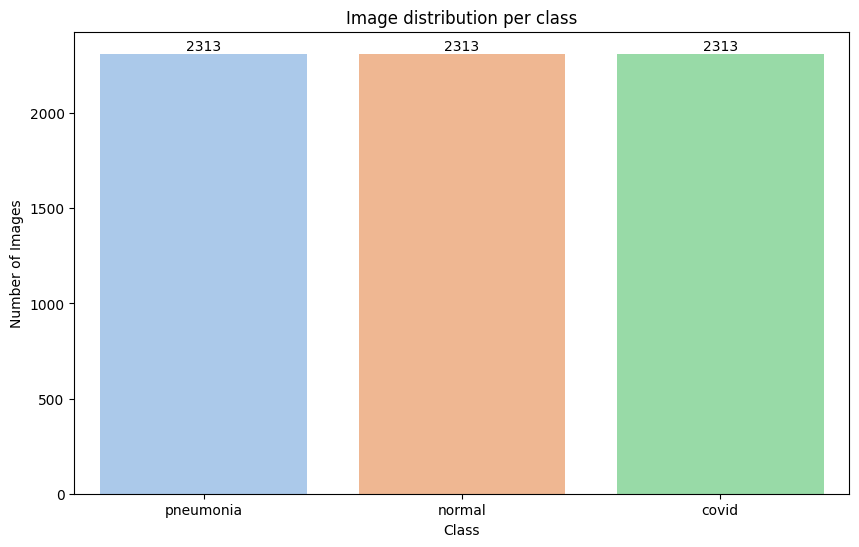

In [2]:
dataset_path = "/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset"

# Kiểm tra tồn tại đường dẫn
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset not found at {dataset_path}")

# Chỉ chấp nhận các đuôi sau (extension)
valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff', '.jfif')

# Hàm để tính số lượng hình ảnh trong mỗi thư mục
def count_imgs(path):
    
    class_dict = {}
    
    # Lặp qua các thư mục con (là tên class)
    for subdir in os.listdir(path):
        class_folder = os.path.join(path, subdir)
        if os.path.isdir(class_folder):
            num_imgs = len([file for file in os.listdir(class_folder) if file.lower().endswith(valid_exts)])
            class_dict[subdir] = num_imgs
    return class_dict

img_per_class = count_imgs(dataset_path)

# Hiển thị phân phối lớp
print("Class distribution:")
for c, num in img_per_class.items():
    print(f"{c}: {num} images")

# Plot Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(img_per_class.values(), labels=img_per_class.keys(), autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Image distribution per class (Pie Chart)')
plt.show()

# Plot Bar Chart
# Chuyển đổi khóa và giá trị thành list và mảng Numpy tương ứng vì seaborn chỉ nhận list hoặc series
class_keys = list(img_per_class.keys())
class_values = list(img_per_class.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=class_keys, y=class_values, palette='pastel')
plt.title('Image distribution per class')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# Displays the value above the bar
for i, value in enumerate(class_values):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')

plt.show()

## 2.2. Trực quan hóa một vài mẫu dữ liệu

Displaying samples for class: normal


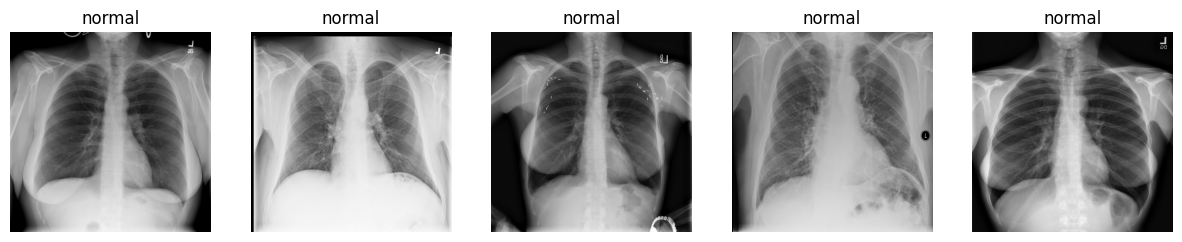

Displaying samples for class: pneumonia


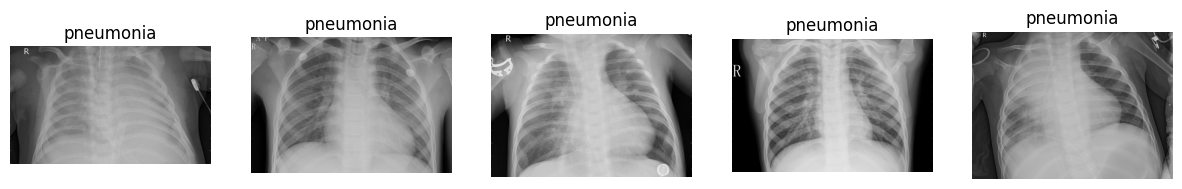

Displaying samples for class: covid


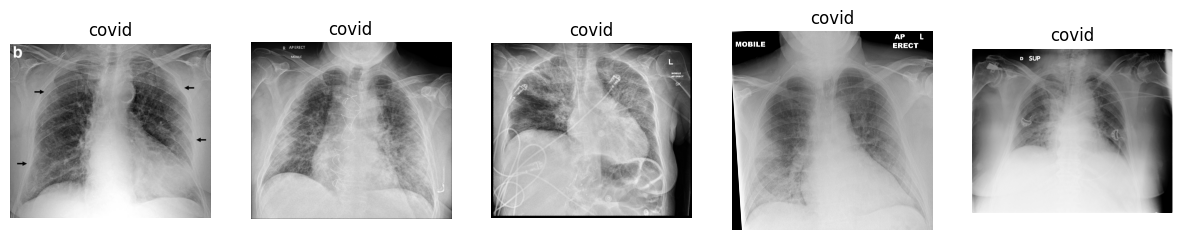

In [3]:
dataset_path = "/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset"

# Hàm hiển thị một vài mẫu ảnh từ mỗi lớp
def show_samples(dataset_path, class_name, num_images=5):
    # Dùng join class_name với dataset_path để tìm class_path
    class_path = os.path.join(dataset_path, class_name)

    # Lấy list ảnh từ class_path
    images = [os.path.join(class_path, f) for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    # Dùng shuffle để lấy ảnh ngẫu nhiên
    random.shuffle(images)
    
    # Plot ảnh
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(images[:num_images]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Định nghĩa class (các folder trong dataset)
class_counts = {'normal': 0, 'pneumonia': 0, 'covid': 0} # chỉ định nghĩa, không sử dụng lại class counts cho huấn luyện

# Hiển thị mẫu dữ liệu
for class_name in class_counts.keys():
    print(f"Displaying samples for class: {class_name}")
    show_samples(dataset_path, class_name)

# 3. Chuẩn bị dữ liệu

## 3.1. Chia tập dữ liệu thành 3 tập train, val và test

In [4]:
# 1. Đặt đường dẫn đến thư mục chứa 3 lớp của bạn
source_dir = "/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset"

# 2. Đặt đường dẫn cho dữ liệu đã được chia
output_dir = '/kaggle/working/chest_xray_split/'

# 3. Tỉ lệ chia
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

print(f"Start the data split from '{source_dir}'...")

# Lấy danh sách các lớp (tên các thư mục con)
try:
    class_names = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    if not class_names:
        raise ValueError("Unable to find class folders in source_dir.")
    print(f"Classes found: {class_names}")
except Exception as e:
    print(f"Error: Unable to read class folder from '{source_dir}'. Please check the path again. Error detail: {e}")
    raise

# Xóa thư mục output nếu đã tồn tại để làm lại từ đầu
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
    print(f"Deleted old directory: '{output_dir}'")

# Chỉ chấp nhận các đuôi sau (extension)
valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff', '.jfif')

# Sử dụng seed 42
random.seed(42)
# Lặp qua từng lớp để chia dữ liệu
for class_name in class_names:
    print(f"\nProcessing: '{class_name}'")
    
    # Tạo các thư mục đích
    os.makedirs(os.path.join(output_dir, 'train', class_name), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val', class_name), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test', class_name), exist_ok=True)

    # Lấy danh sách tất cả các tệp ảnh trong thư mục lớp nguồn
    src_class_dir = os.path.join(source_dir, class_name)
    files = [
        f for f in os.listdir(src_class_dir)
        if os.path.isfile(os.path.join(src_class_dir, f)) and f.lower().endswith(valid_exts)
    ]

    # Xáo trộn danh sách tệp
    random.shuffle(files)

    # Tính toán số lượng tệp cho mỗi tập
    total_files = len(files)
    train_count = int(total_files * train_ratio)
    val_count = int(total_files * val_ratio)
    # test_count là phần còn lại

    # Phân chia và sao chép tệp
    # Tập Train
    for i in range(train_count):
        shutil.copy(os.path.join(src_class_dir, files[i]), os.path.join(output_dir, 'train', class_name, files[i]))
    
    # Tập Validation
    for i in range(train_count, train_count + val_count):
        shutil.copy(os.path.join(src_class_dir, files[i]), os.path.join(output_dir, 'val', class_name, files[i]))

    # Tập Test
    for i in range(train_count + val_count, total_files):
        shutil.copy(os.path.join(src_class_dir, files[i]), os.path.join(output_dir, 'test', class_name, files[i]))
        
    print(f"Total: {total_files} images. Divided into: {train_count} train, {val_count} val, {total_files - train_count - val_count} test.")

print("\nData split completed!")
print(f"Data is ready at path: '{output_dir}'")

Start the data split from '/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset'...
Classes found: ['pneumonia', 'normal', 'covid']

Processing: 'pneumonia'
Total: 2313 images. Divided into: 1619 train, 346 val, 348 test.

Processing: 'normal'
Total: 2313 images. Divided into: 1619 train, 346 val, 348 test.

Processing: 'covid'
Total: 2313 images. Divided into: 1619 train, 346 val, 348 test.

Data split completed!
Data is ready at path: '/kaggle/working/chest_xray_split/'


## 3.2. Tạo dataloader

**Khi thực hiện việc tạo dataloader thì các file jfif không đọc được sử dụng datasets.ImageFolder nên cần chuyển các file này sang dạng .jpg vì theo tìm hiểu, các file này thực chất là file .jpg dạng cũ.**

In [5]:
# --- Hàm chuyển file định dạng jfif sang jpg
def convert_jfif_to_jpg(folder):
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith('.jfif'):
                jfif_path = os.path.join(root, f)
                jpg_path = os.path.join(root, os.path.splitext(f)[0] + '.jpg')
                try:
                    with Image.open(jfif_path) as img:
                        rgb_img = img.convert('RGB')
                        rgb_img.save(jpg_path, 'JPEG')
                    os.remove(jfif_path)  # Xoá file .jfif gốc
                    print(f"Converted: {jfif_path} -> {jpg_path}")
                except Exception as e:
                    print(f"Error with file {jfif_path}: {e}")

convert_jfif_to_jpg('/kaggle/working/chest_xray_split/')

Converted: /kaggle/working/chest_xray_split/val/covid/257.jfif -> /kaggle/working/chest_xray_split/val/covid/257.jpg
Converted: /kaggle/working/chest_xray_split/val/covid/187.jfif -> /kaggle/working/chest_xray_split/val/covid/187.jpg
Converted: /kaggle/working/chest_xray_split/val/covid/406.jfif -> /kaggle/working/chest_xray_split/val/covid/406.jpg
Converted: /kaggle/working/chest_xray_split/val/covid/370.jfif -> /kaggle/working/chest_xray_split/val/covid/370.jpg
Converted: /kaggle/working/chest_xray_split/val/covid/371.jfif -> /kaggle/working/chest_xray_split/val/covid/371.jpg
Converted: /kaggle/working/chest_xray_split/test/covid/373.jfif -> /kaggle/working/chest_xray_split/test/covid/373.jpg
Converted: /kaggle/working/chest_xray_split/test/covid/259.jfif -> /kaggle/working/chest_xray_split/test/covid/259.jpg
Converted: /kaggle/working/chest_xray_split/test/covid/365.jfif -> /kaggle/working/chest_xray_split/test/covid/365.jpg
Converted: /kaggle/working/chest_xray_split/test/covid/165

In [6]:
# --- Đường dẫn tới dữ liệu ---
data_dir = '/kaggle/working/chest_xray_split/'

# --- Định nghĩa các tham số ---
IMG_SIZE = 224 # Kích thước ảnh đầu vào cho ViT
BATCH_SIZE = 32
NUM_CLASSES = 3

# --- Định nghĩa các phép biến đổi (Data Augmentation và Normalization) ---
# Ảnh X-quang thường là ảnh xám, nhưng các mô hình pre-trained thường nhận vào ảnh 3 kênh (RGB)
# ToTensor() sẽ tự chuyển ảnh 1 kênh thành 3 kênh
# Chuẩn hóa theo giá trị trung bình và độ lệch chuẩn của ImageNet
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(), # Tăng cường dữ liệu
        transforms.RandomRotation(10), # Tăng cường dữ liệu
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Tải dữ liệu bằng ImageFolder ---
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, data_transforms['val'])
}

# Lấy tên các lớp (chỉ cần chạy cái này cho phần dự đoán ở cuối, không cần chạy để tạo dataloaders)
class_names = image_datasets['train'].classes
print(f"Classes found: {class_names}")

Classes found: ['covid', 'normal', 'pneumonia']


In [7]:
# --- Tạo DataLoaders ---
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=2),
    'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

dataset_sizes = {
    'train': len(image_datasets['train']),
    'val': len(image_datasets['val']),
    'test': len(image_datasets['test'])
}

print(f"Train data size: {dataset_sizes['train']}")
print(f"Val data size: {dataset_sizes['val']}")
print(f"Test data size: {dataset_sizes['test']}")
print(f"Total: {len(image_datasets['train']) + len(image_datasets['val']) + len(image_datasets['test'])}")

Train data size: 4857
Val data size: 1038
Test data size: 1044
Total: 6939


# 4. Model

In [8]:
# --- Tải mô hình ViT pre-trained ---
# 'vit_base_patch16_224'
# pretrained=True để sử dụng trọng số đã huấn luyện trên ImageNet
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES)

# Chuyển sang GPU nếu có để in summary mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Sử dụng summary từ torchinfo
summary(model, input_size=(1, 3, 224, 224))  # batch_size=1, 3 kênh màu, ảnh 224x224

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [1, 3]                    152,064
├─PatchEmbed: 1-1                        [1, 196, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 14, 14]          590,592
│    └─Identity: 2-2                     [1, 196, 768]             --
├─Dropout: 1-2                           [1, 197, 768]             --
├─Identity: 1-3                          [1, 197, 768]             --
├─Identity: 1-4                          [1, 197, 768]             --
├─Sequential: 1-5                        [1, 197, 768]             --
│    └─Block: 2-3                        [1, 197, 768]             --
│    │    └─LayerNorm: 3-1               [1, 197, 768]             1,536
│    │    └─Attention: 3-2               [1, 197, 768]             2,362,368
│    │    └─Identity: 3-3                [1, 197, 768]             --
│    │    └─Identity: 3-4                [1, 197, 768]           

# 5. Huấn luyện mô hình

In [9]:
# --- Định nghĩa các tham số huấn luyện ---
EPOCHS = 30
LEARNING_RATE = 1e-4
# --- Thiết lập hàm mất mát và trình tối ưu hóa ---
criterion = nn.CrossEntropyLoss()
# AdamW thường hoạt động tốt với các mô hình Transformer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
# Sử dụng một scheduler để giảm learning rate
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [10]:
# --- Tạo class early stopping để dừng mô hình trước khi bị overfitting ---
# Tuy nhiên vẫn sử dụng bộ trọng số epoch cuối
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [11]:
# --- Hàm huấn luyện và đánh giá cho mỗi epoch ---
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    # Vòng lặp
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Mỗi epoch có một pha training và một pha validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Đặt mô hình ở chế độ training
            else:
                model.eval()   # Đặt mô hình ở chế độ evaluation

            running_loss = 0.0
            running_corrects = 0

            # Lặp qua dữ liệu
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Reset gradients
                optimizer.zero_grad()

                # Bật autograd để tính gradient trong pha train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Chỉ thực hiện Backward + optimize trong pha training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Thống kê
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step() # Cập nhật learning rate

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Lưu lại lịch sử
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # --- Kiểm tra early stopping sau khi kết thúc pha validation ---
                early_stopping(epoch_loss)
                if early_stopping.early_stop:
                    print("Early stopping triggered!")
                    return model, history

    return model, history

In [12]:
### Nên bật accelerator sang GPU vì đây là mô hình Vision Transformer rất nặng
# --- Chuyển sang GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Chuyển mô hình tới GPU ---
model = model.to(device)

# --- Bắt đầu huấn luyện ---
model_ft, history = train_model(model, criterion, optimizer, lr_scheduler, num_epochs=EPOCHS)

# --- Lưu lại mô hình đã huấn luyện ---
torch.save(model_ft.state_dict(), 'vit_chest_xray_model.pth')

Using device: cuda
Epoch 1/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.6204 Acc: 0.7490


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.5557 Acc: 0.8343
Epoch 2/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.3230 Acc: 0.8855


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.2862 Acc: 0.9094
Epoch 3/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.2273 Acc: 0.9290


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.2205 Acc: 0.9287
Epoch 4/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.1810 Acc: 0.9421


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.1819 Acc: 0.9422
Epoch 5/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.1759 Acc: 0.9430


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.3898 Acc: 0.8651
Epoch 6/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.1211 Acc: 0.9584


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.1829 Acc: 0.9432
Epoch 7/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.0962 Acc: 0.9675


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.1962 Acc: 0.9374
Epoch 8/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.0900 Acc: 0.9695


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.1843 Acc: 0.9403
Epoch 9/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.0841 Acc: 0.9706


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.1800 Acc: 0.9451
Epoch 10/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.0794 Acc: 0.9724


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.1902 Acc: 0.9470
Epoch 11/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.0687 Acc: 0.9761


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.1728 Acc: 0.9480
Epoch 12/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.0669 Acc: 0.9769


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.1781 Acc: 0.9432
Epoch 13/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.0631 Acc: 0.9784


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.1778 Acc: 0.9470
Epoch 14/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.0607 Acc: 0.9786


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.1790 Acc: 0.9480
Epoch 15/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.0603 Acc: 0.9790


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.1843 Acc: 0.9461
Epoch 16/30
----------


  0%|          | 0/152 [00:00<?, ?it/s]

train Loss: 0.0598 Acc: 0.9796


  0%|          | 0/33 [00:00<?, ?it/s]

val Loss: 0.1843 Acc: 0.9461
Early stopping triggered!


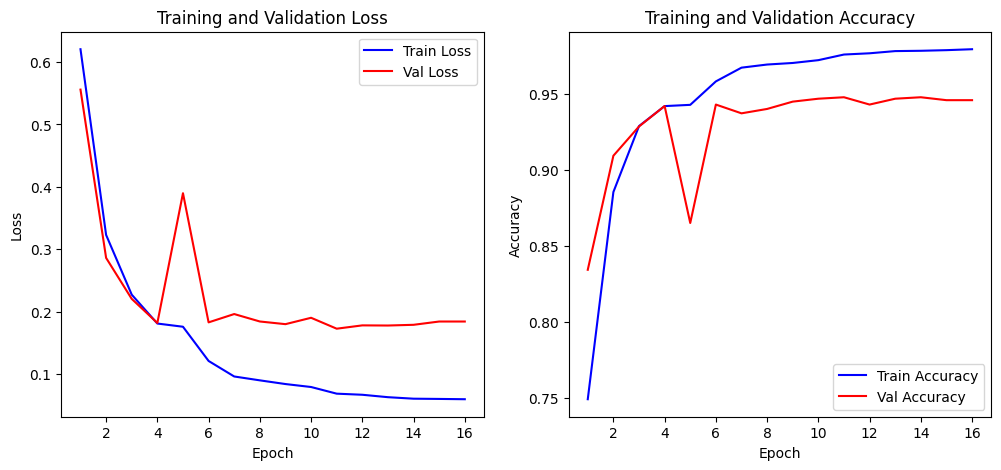

In [13]:
# --- Hàm vẽ biểu đồ huấn luyện qua từng epoch ---
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12,5))

    # Vẽ Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Vẽ Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

# 6. Đánh giá mô hình

In [14]:
# --- Hàm đánh giá trên tập test ---
def evaluate_model(model, test_loader):
    model.eval() # Chuyển sang chế độ evaluation
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, all_preds

Using device: cuda


  0%|          | 0/33 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       covid       0.98      0.98      0.98       348
      normal       0.91      0.96      0.94       348
   pneumonia       0.96      0.91      0.94       348

    accuracy                           0.95      1044
   macro avg       0.95      0.95      0.95      1044
weighted avg       0.95      0.95      0.95      1044



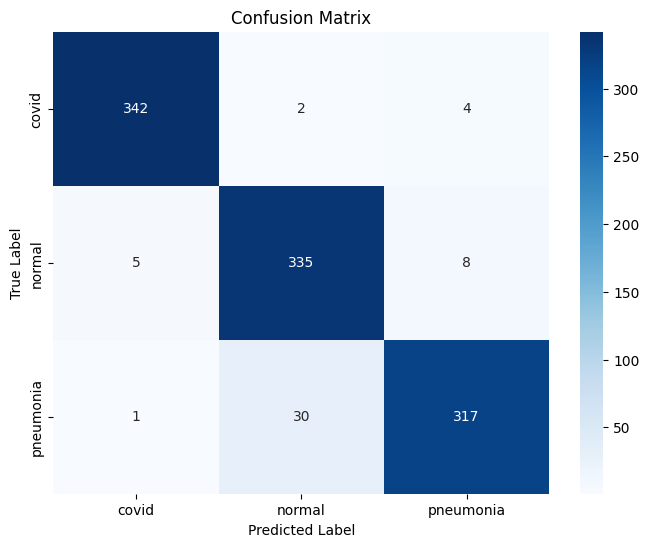

In [15]:
# Load bộ trọng số
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load('/kaggle/working/vit_chest_xray_model.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# --- Lấy kết quả dự đoán ---
true_labels, predicted_labels = evaluate_model(model, dataloaders['test'])

# --- In báo cáo phân loại ---
print("\nClassification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# --- Vẽ ma trận nhầm lẫn ---
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 7. Dự đoán

In [16]:
# --- Thay đổi tùy theo yêu cầu của mô hình ---
input_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Chuẩn ImageNet
                         std=[0.229, 0.224, 0.225])
])

# --- Hàm dự đoán ảnh ---
def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = input_transforms(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
    
    predicted_class = class_names[pred.item()]
    return predicted_class

# --- Hàm plot ảnh ---
def show_image_prediction(image_path, predicted_class):
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

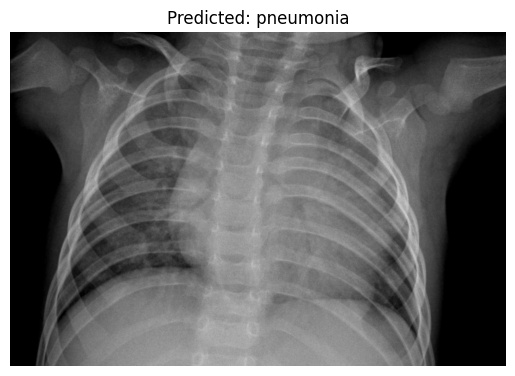

In [17]:
image_path = '/kaggle/input/prediction-covid-normal/NORMAL2-IM-0373-0001.jpeg'
predicted_class = predict_image(image_path, model_ft, class_names)
show_image_prediction(image_path, predicted_class)

In [18]:
# Hàm dự đoán tất cả ảnh trong folder
valid_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff', '.jfif')
def predict_folder(model, class_names, test_folder, output_folder):
    model.eval()  # đặt mô hình ở chế độ evaluation

    # Duyệt qua từng file ảnh trong folder
    for filename in os.listdir(test_folder):
        if filename.lower().endswith(valid_exts):
            image_path = os.path.join(test_folder, filename)
            image = Image.open(image_path).convert('RGB')
            input_tensor = input_transforms(image).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)
                _, pred = torch.max(output, 1)
                predicted_class = class_names[pred.item()]

            # Lưu ảnh đã ghi nhãn
            # split phần name và extension
            name, ext = os.path.splitext(filename)
            # thêm "_predicted_as_{class}"
            save_filename = f"{name}_predicted_as_{predicted_class}{ext}"
            save_path = os.path.join(output_folder, save_filename)
            image.save(save_path)

            print(f'Predicted: {filename} is {predicted_class}')

Predicted: SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg is covid
Predicted: NORMAL2-IM-0340-0001.jpeg is normal
Predicted: SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg is covid
Predicted: NORMAL2-IM-0357-0001.jpeg is normal
Predicted: NORMAL2-IM-0374-0001.jpeg is normal
Predicted: SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg is covid
Predicted: SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg is covid
Predicted: SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg is covid
Predicted: SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg is covid
Predicted: NORMAL2-IM-0352-0001.jpeg is normal
Predicted: NORMAL2-IM-0372-0001.jpeg is normal
Predicted: NORMAL2-IM-0339-0001.jpeg is normal
Predicted: NORMAL2-IM-0373-0001.jpeg is pneumonia
Predicted: NORMAL2-IM-0354-0001.jpeg is normal
Predicted: NORMAL2-IM-0341-0001.jpeg is normal
Predicted: NORMAL2-IM-0353-0001.jpeg is pneumonia
Predicted: NORMAL2-IM-0370-0001.jpeg is pneumonia
Predicted: NORMAL2-IM-0338-0001.jpeg is p

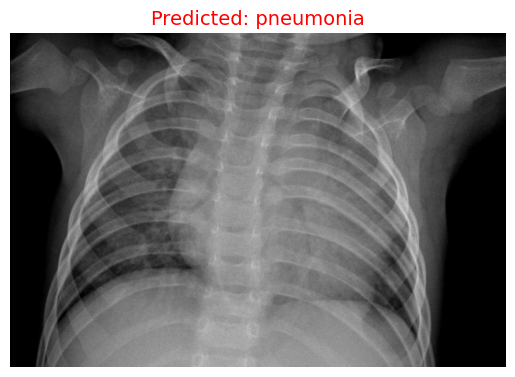

Path:  /kaggle/working/output_test_img_folder/NORMAL2-IM-0338-0001_predicted_as_pneumonia.jpeg


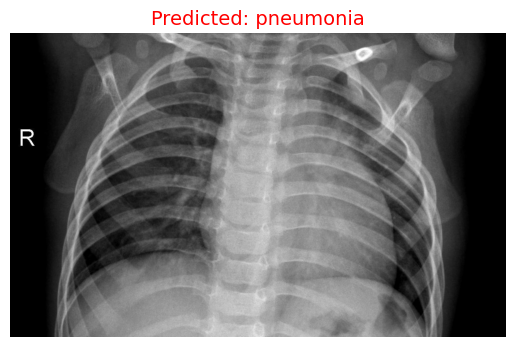

Path:  /kaggle/working/output_test_img_folder/SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10_predicted_as_covid.jpeg


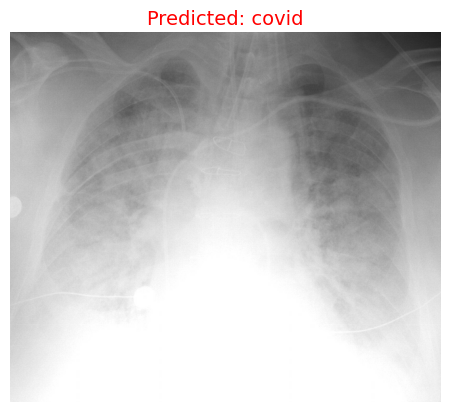

Path:  /kaggle/working/output_test_img_folder/NORMAL2-IM-0340-0001_predicted_as_normal.jpeg


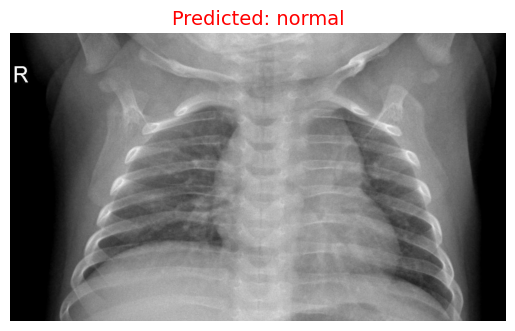

Path:  /kaggle/working/output_test_img_folder/SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7_predicted_as_covid.jpeg


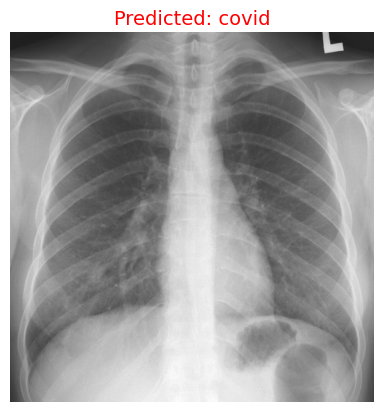

In [19]:
# Link lấy data prediction: https://www.kaggle.com/datasets/fusicfenta/chest-xray-for-covid19-detection
# * Chỉ chứa Normal & Covid
test_img_folder = '/kaggle/input/prediction-covid-normal' # đường dẫn vào folder chứa ảnh test
output_folder = '/kaggle/working/output_test_img_folder'

# Nếu folder tồn tại thì xóa toàn bộ để tạo mới
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)

# Đoán tất cả ảnh trong folder
predict_folder(model, class_names, test_img_folder, output_folder)

# Plot ảnh
predicted_images = os.listdir(output_folder)

# Plot 3 ảnh bất kỳ trong predicted_images
# Trường hợp chỉ có 1 ảnh trong folder thì hiển thị lại ảnh đó 3 lần
for i in range(5):
    img_filename = random.choice(predicted_images)
    img_path = os.path.join(output_folder, img_filename)

    print("Path: ", img_path)
    img = Image.open(img_path)

    # Trích xuất predicted_class từ tên file
    if "_predicted_as_" in img_filename:
        predicted_class_with_extension = img_filename.split("_predicted_as_")[-1] #covid.jpg
        predicted_class = os.path.splitext(predicted_class_with_extension)[0] #covid
    else:
        predicted_class = "Unknown"

    # Hiển thị ảnh và nhãn
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class}', fontsize=14, color='red')
    plt.axis('off')
    plt.show()